In [1]:
import geopandas as gpd
import rasterio 
from rasterio.mask import mask
import numpy as np
import time
from shapely.geometry import box
from shapely import STRtree
from tqdm import tqdm
from rasterio.plot import show
from concurrent.futures import ProcessPoolExecutor

For each geotiff, intersect w/ shapefile grid, finding which hexagons intersect the geotiff.

In [2]:
# Path to your shapefile and GeoTIFF
shapefile_path = 'grid/Colombia_grid_20k.shp'
raster_path = 'bird_maps/Accipiter_bicolor_sp_range.tif'

# Load the shapefile
print('Loading shapefile...')
start_time = time.time()
hexagons = gpd.read_file(shapefile_path)
print('Shapefile loaded in', round(time.time() - start_time, 2), 'seconds')



Loading shapefile...
Shapefile loaded in 24.48 seconds


In [3]:
num_hexagons = len(hexagons)
print('Number of hexagons:', num_hexagons)

Number of hexagons: 186866


## Approach 1
For each raster, iterate over each hexagon of the shapefile. Crop the raster to the hexagon's area, and if there are any non-zero values in the cropped region, that hexagon intersects.

In [25]:
# Open the raster
start_time = time.time()
with rasterio.open(raster_path) as src:
    # Initialize an empty list to hold indices of intersecting hexagons
    intersecting_indices = []
    raster_bounds = src.bounds
    print(f"Raster bounds: {raster_bounds}")

    # Loop through each hexagon
    for index, hexagon in tqdm(hexagons.iterrows(), total=hexagons.shape[0]):
        # Use the geometry to mask the raster, crop=True reduces the output to the bounding box of the mask
        out_image, out_transform = rasterio.mask.mask(src, [hexagon['geometry']], crop=True, nodata=0)
        
        # Check if there's any non-zero value in the masked raster
        if np.any(out_image > 0):  # Change condition based on your specific criteria
            intersecting_indices.append(index)
    
    # Filter hexagons by the indices of intersecting ones
    intersecting_hexagons = hexagons.loc[intersecting_indices]
total_time = time.time() - start_time

print(f'Number of intersecting hexagons: {len(intersecting_hexagons)}')
print(f"Total time: {total_time} seconds")
print(f"Average time per hexagon: {(total_time / num_hexagons) * 1000} ms")

Raster bounds: BoundingBox(left=-81.84444224050868, bottom=-4.236110295492782, right=-66.71943997755751, top=15.916670497475224)


100%|██████████| 186866/186866 [02:47<00:00, 1118.58it/s]

Number of intersecting hexagons: 54414
Total time: 167.07610630989075 seconds
Average time per hexagon: 0.8940958029277168 ms


In [10]:
def process_hexagon(hexagon, raster_path):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [hexagon['geometry']], crop=True, nodata=0)
        if np.any(out_image > 0):  # Adjust condition as necessary
            return True  # Indicate intersection
    return False

# Open the raster
start_time = time.time()
# Initialize an empty list to hold indices of intersecting hexagons
intersecting_indices = []

# Use ProcessPoolExecutor to parallelize
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_hexagon, hexagon, raster_path) for index, hexagon in hexagons.iterrows()]
    
    for index, future in enumerate(futures):
        if future.result():
            intersecting_indices.append(hexagons.iloc[index].name)

intersecting_hexagons = hexagons.loc[intersecting_indices]
total_time = time.time() - start_time
print(f'Number of intersecting hexagons: {len(intersecting_hexagons)}')
print(f"Total time: {total_time} seconds")
print(f"Average time per hexagon: {(total_time / num_hexagons) * 1000} ms")

Number of intersecting hexagons: 54414
Total time: 241.90204739570618 seconds
Average time per hexagon: 1.294521461345061 ms


In [10]:
intersecting_hexagons.to_file('intersecting_hexagons.shp')

## Approach 2


In [29]:
from shapely.geometry import shape

# Assuming you have a raster and you've obtained its bounding box
start_time = time.time()
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)

    mask = raster_data > 0

    # Vectorize the masked area.
    shapes = rasterio.features.shapes(raster_data, mask=mask, transform=src.transform)

    # Convert shapes to shapely geometries
    geometries = [shape(geom) for geom, value, in shapes if value == 1]

    # Create a GeoDataFrame from geometries
    raster_polygons = gpd.GeoDataFrame(geometry=geometries, crs=src.crs)

# Perform spatial intersection
intersecting_hexagons = gpd.overlay(hexagons, raster_polygons, how='intersection')  
total_time = time.time() - start_time

print(f'Number of intersecting hexagons: {len(intersecting_hexagons)}')
print(f"Total time: {total_time} seconds")
print(f"Average time per hexagon: {(total_time / num_hexagons) * 1000} ms")


# Method 3

In [15]:
from shapely.geometry import shape

start_time = time.time()

with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    
    # Create a mask for pixels above a threshold (e.g., greater than 0)
    mask = raster_data > 0

    # Vectorize the masked area
    shapes = rasterio.features.shapes(raster_data, mask=mask, transform=src.transform)
    
    # Convert shapes to Shapely geometries
    geometries = [shape(geom) for geom, value in shapes if value == 1]
    
    # Create an STRtree from these geometries
    tree = STRtree(geometries)

print(f"STRtree created in {time.time() - start_time} seconds")

# Prepare a list for intersecting hexagons
intersecting_hexagons = []

# Iterate over hexagons to check for intersection using the STR tree
for hexagon in hexagons.geometry:
    # Query the tree with the current hexagon
    # This returns a list of geometries from the tree that intersect with the hexagon
    possible_intersects = tree.query(hexagon)
    
    # Check for actual intersections and add to list if true
    for geom in possible_intersects:
        if hexagon.intersects(geom):
            intersecting_hexagons.append(hexagon)
            break  # Assuming we only need to know if at least one intersection occurs

total_time = time.time() - start_time
num_hexagons = len(hexagons)

print(f'Number of intersecting hexagons: {len(intersecting_hexagons)}')
print(f"Total time: {total_time} seconds")
print(f"Average time per hexagon: {(total_time / num_hexagons) * 1000} ms")

STRtree created in 1.087012767791748 seconds


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

STRtree created
Number of raster polygons: 762
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265

KeyboardInterrupt: 

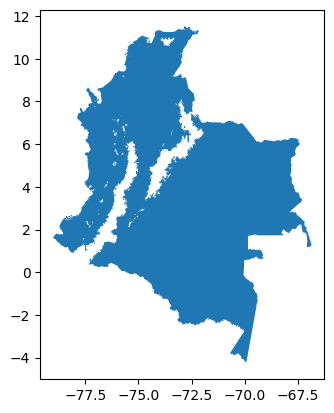

In [26]:
from shapely.strtree import STRtree
import geopandas as gpd
import rasterio
import rasterio.features
from shapely.geometry import shape
import time
import matplotlib as plt

# Build an STR tree from the hexagons
hexagon_tree = STRtree(hexagons.geometry)
print("STRtree created")

def process_raster(raster_path):
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)
        mask = raster_data > 0  # Adjust this threshold as necessary
        shapes = rasterio.features.shapes(raster_data, mask=mask, transform=src.transform)
        geometries = [shape(geom) for geom, value in shapes if value == 1]
        print(f"Number of raster polygons: {len(geometries)}")

        raster_polygons = gpd.GeoDataFrame(geometry=geometries, crs=src.crs)
        raster_polygons.plot()

    # List to hold results
    intersecting_hexagons = []

    # For each geometry from the raster, find intersecting hexagons
    for i, geom in enumerate(geometries):
        if i == 760:
            print('here!')

        # Query the hexagon tree for potential intersects
        candidates = hexagon_tree.query(geom)
        hex_geoms = hexagon_tree.geometries.take(candidates).tolist()

        # Perform actual intersection test
        intersecting_geometries = [h for h in hex_geoms if h.intersects(geom)]
        intersecting_hexagons.extend(intersecting_geometries)
        print(i)


        
    return intersecting_hexagons

# Example usage
start_time = time.time()
intersecting_hexagons = process_raster(raster_path)
total_time = time.time() - start_time

num_hexagons = len(hexagons)
print(f'Number of intersecting hexagons: {len(intersecting_hexagons)}')
print(f"Total time: {total_time} seconds")
print(f"Average time per hexagon: {(total_time / num_hexagons) * 1000} ms")

intersect_gpd = gpd.GeoDataFrame(geometry=intersecting_hexagons, crs=hexagons.crs)
intersect_gpd.plot()
intersect_gpd.to_file('intersecting_hexagons_v2.shp')

